# Demo 04 - Regression Analysis

Up to this point, we've performed basic descriptive analytics, looking at counts.  We can also use regression analysis to help us understand our data better.

In [1]:
if(!require(tidyverse)) {
    install.packages("tidyverse", repos = "http://cran.us.r-project.org")
    library(tidyverse)
}

if(!require(odbc)) {
    install.packages("odbc", repos = "http://cran.us.r-project.org")
    library(odbc)
}

# ggplot2 is installed with the tidyverse.
library(ggplot2)

Loading required package: tidyverse
Warning message:
"package 'tidyverse' was built under R version 3.5.2"-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.0     v purrr   0.2.5
v tibble  1.4.2     v dplyr   0.7.6
v tidyr   0.8.1     v stringr 1.3.1
v readr   1.1.1     v forcats 0.3.0
Warning message:
"package 'ggplot2' was built under R version 3.5.2"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Loading required package: odbc
Warning message:
"package 'odbc' was built under R version 3.5.3"

## Regressing Expenditures Against Bus Counts

We have data broken down by month to try to avoid some of the noise while still giving us enough data points for regression.

In [2]:
conn <- DBI::dbConnect(odbc::odbc(), 
                      Driver = "SQL Server", 
                      Server = "localhost", 
                      Database = "ForensicAccounting", 
                      Trusted_Connection = "True")

In [3]:
expenditures <- DBI::dbGetQuery(conn, "WITH buses AS
(
	SELECT
		c.FirstDayOfMonth,
		c.CalendarMonth,
		c.CalendarYear,
		COUNT(*) AS NumberOfBuses
	FROM dbo.Bus b
		INNER JOIN dbo.Calendar c
			ON b.DateFirstInService <= c.Date
			AND ISNULL(b.DateRetired, '2018-12-31') >= c.Date
	WHERE
		c.Date = c.FirstDayOfMonth
		AND c.CalendarYear >= 2011
		AND c.CalendarYear < 2019
	GROUP BY
		c.FirstDayOfMonth,
		c.CalendarMonth,
		c.CalendarYear
),
expenses AS
(
	SELECT
		c.FirstDayOfMonth,
		COUNT(*) AS NumberOfInvoices,
		SUM(li.Amount) AS TotalInvoicedAmount
	FROM dbo.LineItem li
		INNER JOIN dbo.Calendar c
			ON li.LineItemDate = c.Date
	GROUP BY
	c.FirstDayOfMonth
)
SELECT
	b.FirstDayOfMonth,
	b.CalendarMonth,
	b.CalendarYear,
	b.NumberOfBuses,
	e.NumberOfInvoices,
	e.TotalInvoicedAmount
FROM buses b
	INNER JOIN expenses e
		ON b.FirstDayOfMonth = e.FirstDayOfMonth
ORDER BY
	b.FirstDayOfMonth;
")

In [4]:
summary(expenditures)

 FirstDayOfMonth    CalendarMonth    CalendarYear  NumberOfBuses  
 Length:96          Min.   : 1.00   Min.   :2011   Min.   :314.0  
 Class :character   1st Qu.: 3.75   1st Qu.:2013   1st Qu.:352.0  
 Mode  :character   Median : 6.50   Median :2014   Median :391.0  
                    Mean   : 6.50   Mean   :2014   Mean   :388.2  
                    3rd Qu.: 9.25   3rd Qu.:2016   3rd Qu.:441.0  
                    Max.   :12.00   Max.   :2018   Max.   :491.0  
 NumberOfInvoices TotalInvoicedAmount
 Min.   :228.0    Min.   : 39783     
 1st Qu.:319.2    1st Qu.: 60936     
 Median :364.5    Median : 71342     
 Mean   :390.2    Mean   : 80961     
 3rd Qu.:425.2    3rd Qu.: 81576     
 Max.   :871.0    Max.   :253762     

The `lm()` function allows us to build a linear regression quickly in R.  Our assumption is that bus expenditures scale linearly with respect to the number of buses in our fleet.  This might not be a perfect understanding of the data but should be good for a first glance.

In [5]:
reg <- lm(formula = TotalInvoicedAmount ~ NumberOfBuses, data = expenditures)

In [6]:
summary(reg)


Call:
lm(formula = TotalInvoicedAmount ~ NumberOfBuses, data = expenditures)

Residuals:
   Min     1Q Median     3Q    Max 
-52900 -17880  -2927   6702 131081 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -121888.40   26347.88  -4.626 1.19e-05 ***
NumberOfBuses     522.58      67.31   7.764 9.94e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 33450 on 94 degrees of freedom
Multiple R-squared:  0.3907,	Adjusted R-squared:  0.3843 
F-statistic: 60.28 on 1 and 94 DF,  p-value: 9.938e-12


As a first approximation, the number of buses explains about 38% of the variance in data.  This graph can show us why:

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


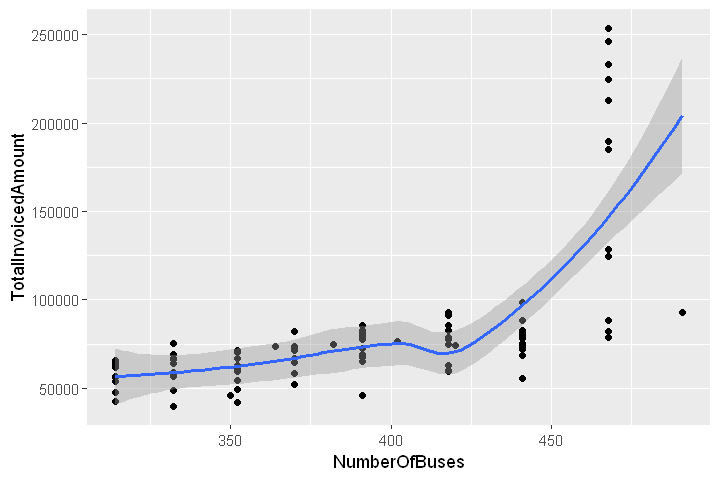

In [7]:
options(repr.plot.width=6, repr.plot.height=4) 
ggplot(data = expenditures, aes(x = NumberOfBuses, y = TotalInvoicedAmount)) +
    geom_point() +
    geom_smooth()

But remember that we saw the data in 2018 spike.  Given that, let's see how the regression works prior to 2018.

In [8]:
regPre2018 <- lm(formula = TotalInvoicedAmount ~ NumberOfBuses,
                 data = filter(expenditures, lubridate::year(FirstDayOfMonth) < 2018))

In [9]:
summary(regPre2018)


Call:
lm(formula = TotalInvoicedAmount ~ NumberOfBuses, data = filter(expenditures, 
    lubridate::year(FirstDayOfMonth) < 2018))

Residuals:
     Min       1Q   Median       3Q      Max 
-24749.7  -4618.9    -23.9   7028.9  18342.5 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -2515.07    9311.20   -0.27    0.788    
NumberOfBuses   187.24      24.57    7.62 3.93e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 9668 on 82 degrees of freedom
Multiple R-squared:  0.4146,	Adjusted R-squared:  0.4074 
F-statistic: 58.06 on 1 and 82 DF,  p-value: 3.933e-11


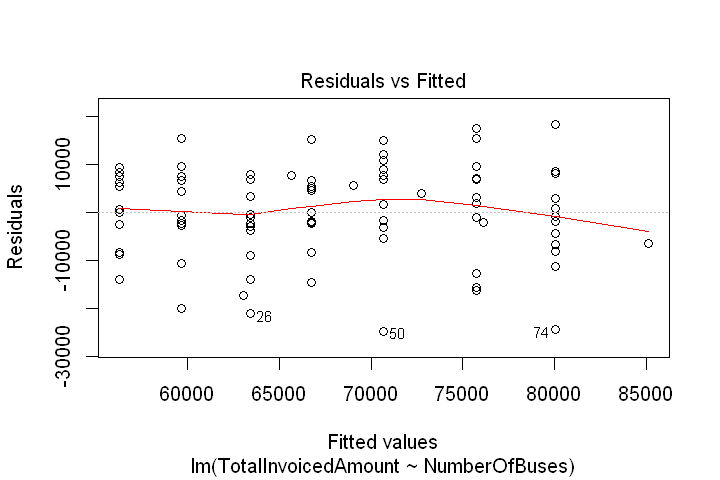

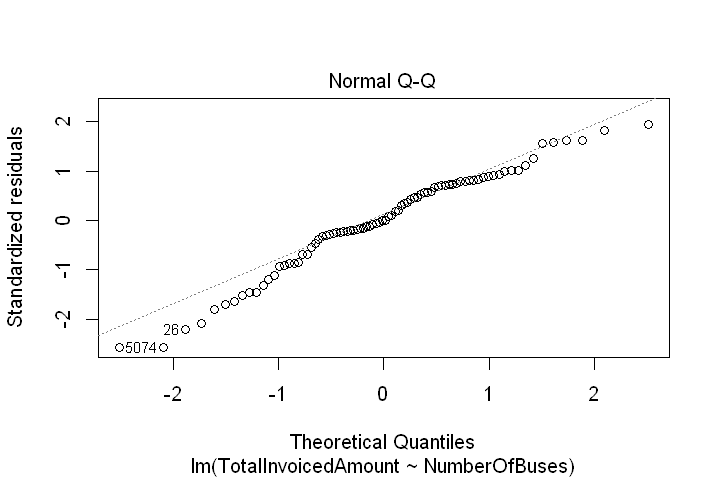

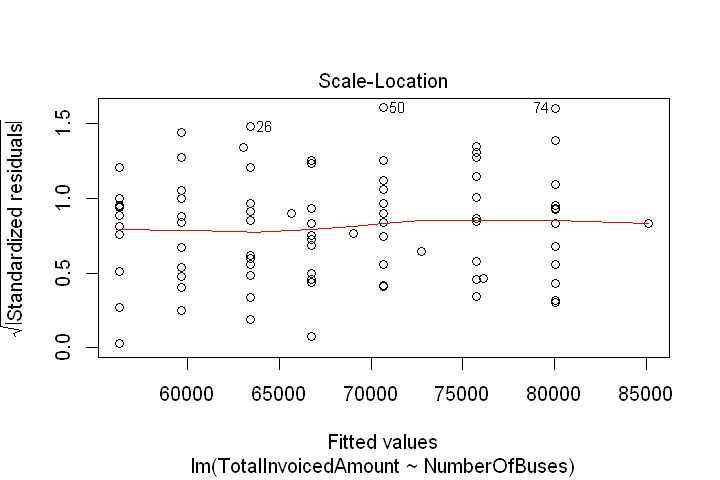

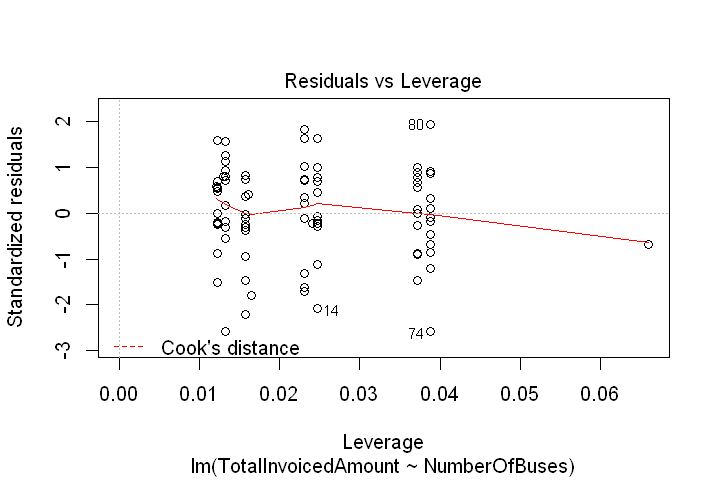

In [10]:
options(repr.plot.width=6, repr.plot.height=4) 
plot(regPre2018)

It turns out that this is only a minor improvement.  But let's look at counts.

## Regressing Invoice Counts Against Bus Counts

In [11]:
regICPre2018 <- lm(formula = NumberOfInvoices ~ NumberOfBuses,
                 data = filter(expenditures, lubridate::year(FirstDayOfMonth) < 2018))

In [12]:
summary(regICPre2018)


Call:
lm(formula = NumberOfInvoices ~ NumberOfBuses, data = filter(expenditures, 
    lubridate::year(FirstDayOfMonth) < 2018))

Residuals:
     Min       1Q   Median       3Q      Max 
-106.500  -31.232    8.396   29.740  108.119 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -13.5276    44.2825  -0.305    0.761    
NumberOfBuses   0.9771     0.1169   8.361 1.34e-12 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 45.98 on 82 degrees of freedom
Multiple R-squared:  0.4602,	Adjusted R-squared:  0.4536 
F-statistic:  69.9 on 1 and 82 DF,  p-value: 1.345e-12


Doing this against the count of invoices gives us an R^2 of 0.45, so it's a moderate regression.  So maybe there's a bit too much noise in the monthly data.

We might also be missing an important variable.  Number of buses is significant according to our probability test---its p-value is tiny.  A small p-value isn't proof of anything but here the result fits our intuition:  more buses means more invoices.  Specifically, we get approximately 1 invoice per bus per month--the estimate is 0.9771, so I'm rounding it for purposes of understanding and because these estimates have error bars, meaning it's not exactly 0.9771 but some range around 0.9771.

That aside, let's see if we can do better here.  The three variables we have in our SQL query are number of buses, calendar month and calendar year.  Let's see how adding the calendar dates change our results.  First we'll add month.

In [13]:
regICPre2018 <- lm(formula = NumberOfInvoices ~ NumberOfBuses + CalendarMonth,
                 data = filter(expenditures, lubridate::year(FirstDayOfMonth) < 2018))

In [14]:
summary(regICPre2018)


Call:
lm(formula = NumberOfInvoices ~ NumberOfBuses + CalendarMonth, 
    data = filter(expenditures, lubridate::year(FirstDayOfMonth) < 
        2018))

Residuals:
    Min      1Q  Median      3Q     Max 
-96.690 -31.292   8.387  33.687 104.081 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -34.2890    45.9290  -0.747    0.457    
NumberOfBuses   0.9936     0.1164   8.537 6.53e-13 ***
CalendarMonth   2.2335     1.4474   1.543    0.127    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 45.6 on 81 degrees of freedom
Multiple R-squared:  0.4756,	Adjusted R-squared:  0.4626 
F-statistic: 36.73 on 2 and 81 DF,  p-value: 4.432e-12


There is a **very** small change in the R^2 from 45% to 46% of variance explained.  Not only is that nothing to write home about, it's indistinguishable from noise.

How about if we use calendar year instead?

In [15]:
regICPre2018 <- lm(formula = NumberOfInvoices ~ NumberOfBuses + CalendarYear,
                 data = filter(expenditures, lubridate::year(FirstDayOfMonth) < 2018))

In [16]:
summary(regICPre2018)


Call:
lm(formula = NumberOfInvoices ~ NumberOfBuses + CalendarYear, 
    data = filter(expenditures, lubridate::year(FirstDayOfMonth) < 
        2018))

Residuals:
     Min       1Q   Median       3Q      Max 
-109.406  -33.427    8.104   32.726  107.198 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)
(Intercept)   -1.716e+04  2.444e+04  -0.702    0.485
NumberOfBuses  5.855e-01  5.702e-01   1.027    0.308
CalendarYear   8.588e+00  1.224e+01   0.702    0.485

Residual standard error: 46.12 on 81 degrees of freedom
Multiple R-squared:  0.4634,	Adjusted R-squared:  0.4502 
F-statistic: 34.98 on 2 and 81 DF,  p-value: 1.121e-11


Now this result is quite interesting.  Our R^2 didn't change but now neither variable is significant!  This is a great example of something called multicollinearity, one of the challenges of regression.  Put simply, the number of buses increases by about the same number every year, so there is very high correlation between number of buses and calendar year:

In [17]:
exp2017 <- filter(expenditures, lubridate::year(FirstDayOfMonth) < 2018)
cor(exp2017$NumberOfBuses, exp2017$CalendarYear)

[1] 0.9786386

That is, 97.9% of the variance reflected in buses is also reflected in year.  These two variables are **co-linear**.  Because these two variables move almost 1 for 1, it is difficult for the regression algorithm to separate behavior in one versus the other.  They're both fighting to explain the same variance and so both end up with higher p-values.  Also of interest is that the R^2 doesn't change.  Multicollinearity doesn't make your overall predictions worse, but it does make it tougher to tell which independent variables are driving the change.

This is an extreme scenario, mind you, but mutlicollinearity is a common enough occurrence that you will want to be on the lookout for it.

Now let's take a step back, as we're not getting the job done with regressing at the month level.

## Regressing Annual Data

Let's look at annual data to see if this is a tighter fit.

In [18]:
annualExpenditures <- DBI::dbGetQuery(conn, "WITH buses AS
(
	SELECT
		c.CalendarYear,
		COUNT(*) AS NumberOfBuses
	FROM dbo.Bus b
		INNER JOIN dbo.Calendar c
			ON b.DateFirstInService <= c.Date
			AND ISNULL(b.DateRetired, '2018-12-31') >= c.Date
	WHERE
		c.CalendarDayOfYear = 1
		AND c.CalendarYear >= 2011
		AND c.CalendarYear < 2019
	GROUP BY
		c.CalendarYear
),
expenses AS
(
	SELECT
		c.CalendarYear,
		COUNT(*) AS NumberOfInvoices,
		SUM(li.Amount) AS TotalInvoicedAmount
	FROM dbo.LineItem li
		INNER JOIN dbo.Calendar c
			ON li.LineItemDate = c.Date
	GROUP BY
	c.CalendarYear
)
SELECT
	b.CalendarYear,
	b.NumberOfBuses,
	e.NumberOfInvoices,
	e.TotalInvoicedAmount
FROM buses b
	INNER JOIN expenses e
		ON b.CalendarYear = e.CalendarYear
ORDER BY
	b.CalendarYear;
")

In [19]:
regICAnnualPre2018 <- lm(formula = NumberOfInvoices ~ NumberOfBuses,
                 data = filter(annualExpenditures, CalendarYear < 2018))

In [20]:
summary(regICAnnualPre2018)


Call:
lm(formula = NumberOfInvoices ~ NumberOfBuses, data = filter(annualExpenditures, 
    CalendarYear < 2018))

Residuals:
      1       2       3       4       5       6       7 
-88.842  96.831 -55.448   3.799  60.520  75.029 -91.889 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -892.3481   341.9814  -2.609   0.0477 *  
NumberOfBuses   12.7377     0.8428  15.113  2.3e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 87.29 on 5 degrees of freedom
Multiple R-squared:  0.9786,	Adjusted R-squared:  0.9743 
F-statistic: 228.4 on 1 and 5 DF,  p-value: 2.298e-05


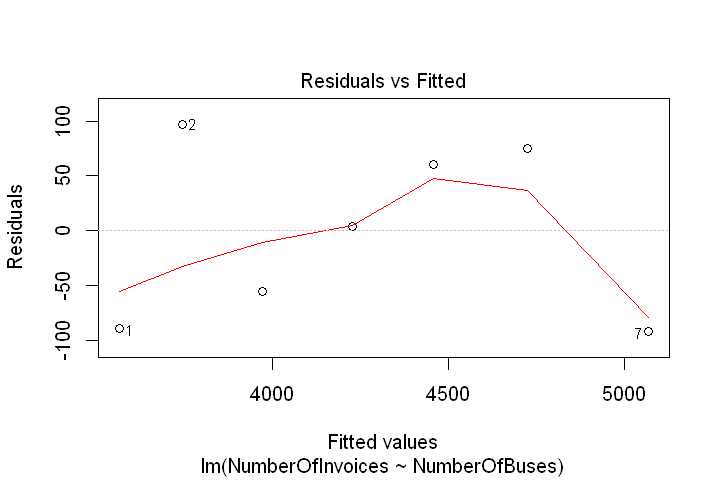

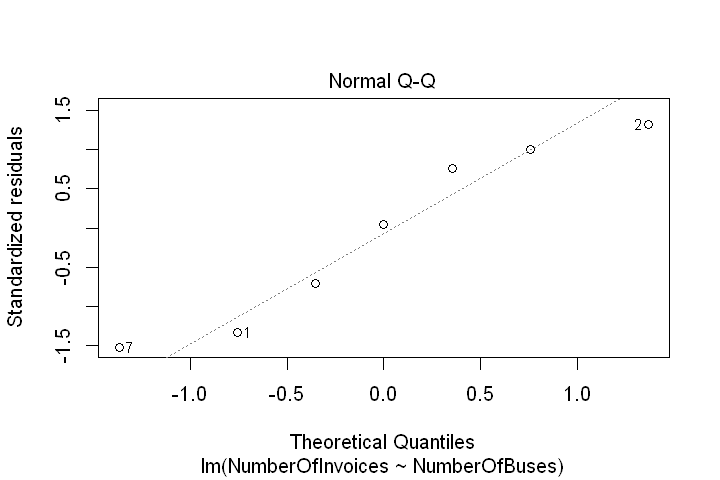

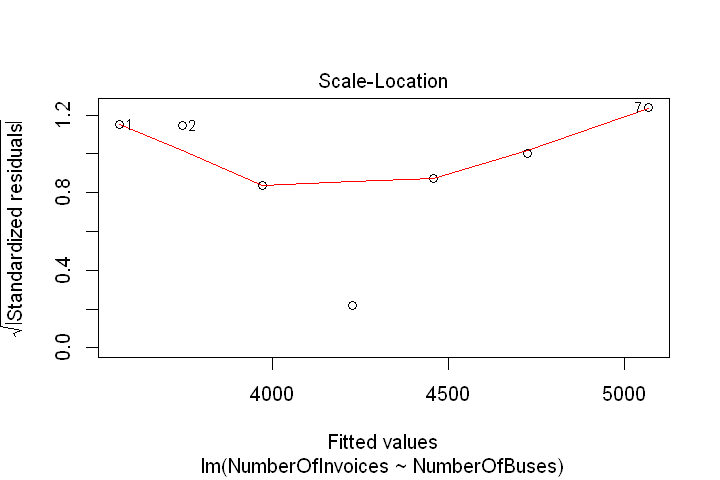

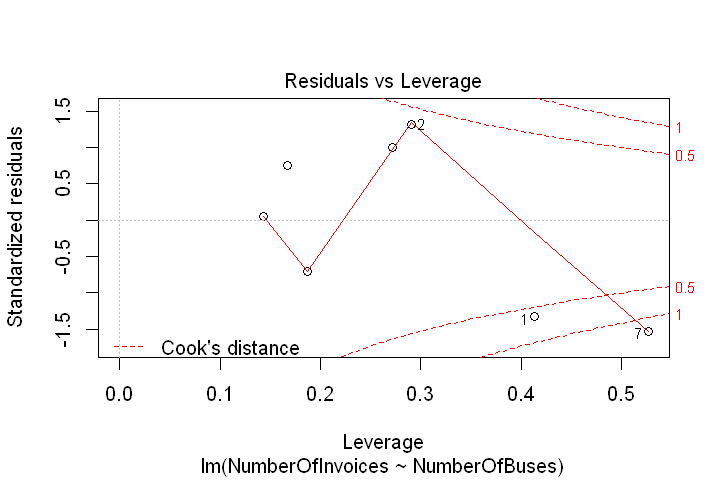

In [21]:
options(repr.plot.width=6, repr.plot.height=4) 
plot(regICAnnualPre2018)

Now we have a 97% R^2.  At the annual level, these differences seem to smooth out.  The number of data points is small so be forewarned but it looks stable.  Now let's look at it with 2018 data in.

In [22]:
regICAnnual <- lm(formula = NumberOfInvoices ~ NumberOfBuses,
                 data = annualExpenditures)

In [23]:
summary(regICAnnual)


Call:
lm(formula = NumberOfInvoices ~ NumberOfBuses, data = annualExpenditures)

Residuals:
    Min      1Q  Median      3Q     Max 
-930.72 -335.89  -84.58  293.99 1263.23 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   -4857.145   2236.150  -2.172  0.07285 . 
NumberOfBuses    23.002      5.358   4.293  0.00513 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 706.1 on 6 degrees of freedom
Multiple R-squared:  0.7544,	Adjusted R-squared:  0.7135 
F-statistic: 18.43 on 1 and 6 DF,  p-value: 0.005131


Note that the R^2 drops from 97% to 71%.  That's a pretty big drop for one year.

One last thing is, I'd like to see what the previous model would have predicted for 2018.  We can use the `predict()` function to perform this operation easily.

In [24]:
predict(regICAnnualPre2018, newdata = filter(annualExpenditures, CalendarYear == 2018))

1 
5361.855

In [25]:
annualExpenditures %>% arrange(desc(CalendarYear))

CalendarYear,NumberOfBuses,NumberOfInvoices,TotalInvoicedAmount
2018,491,7700,2061966.8
2017,468,4977,947527.5
2016,441,4800,923023.6
2015,420,4518,880116.3
2014,402,4232,818787.0
2013,382,3918,735916.2
2012,364,3841,735574.3
2011,350,3477,669353.4
